# AI 01: Model polynomiální regrese (Polynomial Regression Model)

Cílem experimentu bylo ověřit vliv podílu syntetických dat v trénovací množině na přesnost predikce doby trvání pracovní smyčky v závislosti na délce trajektorie.

Import libraries: 

In [1]:
# Instalace potřebných knihoven
#%pip instal pandas
#%pip install numpy

#%pip install scipy
#%pip install seaborn

#%pip install scikit-learn
#%pip install matplotlib
#%pip install seaborn

# actual installed version of sklearn
#%pip show scikit-learn

In [2]:
# Import potřebných knihoven
import pandas as pd
import numpy as np

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Příprava trénovacích, testovacích a validačních dat

In [3]:
# Soubor je načten a přiřazen do proměnné ‚df_train_real‘
path='../../data/06_AI/train/train_timelaps.csv'
df_train_real = pd.read_csv(path)
df_train_real.head()

,id,x,y,z,time,delay,type_delay,total_time
0,150,1315,220,1000,29,0,0,29
1,75,220,1190,500,33,0,0,33
2,239,220,940,2000,35,6,3,41
3,199,1315,220,1500,36,0,0,36
4,51,3690,220,250,50,0,0,50


In [4]:
# Soubor je načten a přiřazen do proměnné ‚df_val_real‘
path='../../data/06_AI/val/valid_timelaps.csv'
df_val_real = pd.read_csv(path)
df_val_real.head()

,id,x,y,z,time,delay,type_delay,total_time
0,13,220,2940,0,32,0,0,32
1,77,220,1690,500,33,23,2,56
2,220,2190,220,1750,35,0,0,35
3,105,252,220,750,53,0,0,53
4,45,2190,220,250,45,0,0,45


### Funkce pro výpočet dráhy trajektorie od referenčního bodu k cílové poloze prvku

In [5]:
# SPECIFIKACE TECHNOLOGICKÉHO PROCESU ZDĚNÍ

brick_thickness = 440     # mm, tloušťka zdicího prvku (Porotherm 440 Profi)
brick_height = 250        # mm, výška zdicího prvku (Porotherm 440 Profi)
brick_width = 250         # mm, šířka zdicího prvku (Porotherm 440 Profi)

# SOUŘADNICE REFERENČNÍHO BODU (nad verifikačním stolem)

refer_x = 2_000           # mm, souřadnice X referenčního bodu
refer_y = 3_500           # mm, souřadnice Y referenčního bodu
refer_z = 1_000           # mm, souřadnice Z referenčního bodu

In [6]:
def calculation_dist(x, y, z):
    """
    Funkce pro výpočet dráhy trajektorie od referenčního bodu k cílové poloze prvku

    Parametry:
    x, y, z (int): souřadnice cílové polohy prvku [mm]

    Návratová hodnota:
    dist (int): dráha trajektorie od referenčního bodu k cílové poloze prvku [mm]
    """
    dist = 0

    # Fáze 1: dráha od referenčního bodu k cílové stěně.
    dist = ((refer_z - (z + brick_height*2))**2 + (refer_x - brick_thickness//2)**2)**(1/2)

    # Fáze 2: dráha ve směru osy X
    if x != brick_thickness / 2:
        dist = dist + abs(x - brick_thickness//2 + brick_width * 2)

    # Fáze 3: dráha ve směru osy Y
    if y != brick_thickness / 2:
        dist = dist + abs(y - refer_y + brick_width * 2)

    return int(dist)

In [7]:
# Funkce pro výpočet dráhy trajektorie od referenčního bodu k cílové poloze prvku
# Pro každý řádek datového rámce je aplikována funkce calculation_dist
# na základě souřadnic 'x','y','z'.
df_train_real['dist'] = df_train_real.apply(lambda x : calculation_dist(x['x'],x['y'],x['z']) , axis=1)
df_train_real = df_train_real[['dist', 'total_time']]
df_train_real.head()

,dist,total_time
0,3443,29
1,3590,33
2,4387,41
3,3636,36
4,5767,50


In [8]:
# Funkce pro výpočet dráhy trajektorie od referenčního bodu k cílové poloze prvku
# Pro každý řádek datového rámce je aplikována funkce calculation_dist
# na základě souřadnic 'x','y','z'.
df_val_real['dist'] = df_val_real.apply(lambda x : calculation_dist(x['x'],x['y'],x['z']) , axis=1)
df_val_real = df_val_real[['dist', 'total_time']]
df_val_real.head()

,dist,total_time
0,1908,32
1,3090,56
2,4645,35
3,2329,53
4,4267,45


In [9]:
df_train_real.describe()

,dist,total_time
count,161.000000,161.000000
mean,3905.074534,41.993789
std,1216.112302,27.037358
min,1840.000000,24.000000
25%,2875.000000,32.000000
50%,3767.000000,36.000000
75%,4744.000000,42.000000
max,6609.000000,250.000000


In [10]:
df_val_real.describe()

,dist,total_time
count,108.000000,108.000000
mean,3861.675926,41.796296
std,1199.683376,28.458450
min,1908.000000,22.000000
25%,2856.500000,32.750000
50%,3911.500000,36.500000
75%,4794.000000,42.000000
max,6466.000000,296.000000


In [11]:
# Soubor je načten a přiřazen do proměnné ‚df_train_syn"
other_path = '../../data/05_Calibration/synthetic_dataset.csv'
df_train_syn = pd.read_csv(other_path, header=0)
#df_train_syn[['dist', 'total_time']] = df_train_syn[['dist', 'total_time']].round().astype(int)
df_train_syn.head()

,dist,total_time
0,5195,38.933762
1,5611,40.150066
2,2714,33.359114
3,5935,41.106167
4,3184,34.030619


In [12]:
df_train_syn.describe()

,dist,total_time
count,500000.000000,500000.000000
mean,3901.498332,40.691468
std,1560.017891,20.473294
min,1200.000000,27.948727
25%,2551.000000,33.322842
50%,3897.000000,36.741907
75%,5249.000000,40.176527
max,6600.000000,204.146807


### Funkce pro polynomiální regresi

In [13]:
def train_polynomial_model(X_train, y_train, X_val, y_val,
                           X_test, y_test, degree, scenario, train_size):

    poly = PolynomialFeatures(degree=3)

    # Transformace
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    X_test_poly = poly.transform(X_test)

    # Model
    model = LinearRegression()

    # Trenovani
    model.fit(X_train_poly, y_train)

    # Validace
    y_val_pred = model.predict(X_val_poly)
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    # Testovani (FINAL evaluation)
    y_test_pred = model.predict(X_test_poly)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    results = {
        'Scenar': scenario,
        'Train_samples': train_size,
        'Degree': degree,
        'Val MSE': val_mse,
        'Val R2': val_r2,
        'Test MSE': test_mse,
        'Test R2': test_r2
    }

    return results

In [14]:
def plot_with_regression(ax, X, y, title, degree, xlim, ylim):
    # převod na 1D (kdyby byly shape (n,1))
    X = np.ravel(X)
    y = np.ravel(y)

    # linear regression (1st degree polyfit)
    coef = np.polyfit(X, y, 1)
    reg_line = np.poly1d(coef)

    # sort kvůli hezké čáře
    sort_idx = np.argsort(X)
    X_sorted = X[sort_idx]

    # fit polynomu
    coef = np.polyfit(X, y, degree)
    poly = np.poly1d(coef)

    # vytvoření hladké křivky
    X_curve = np.linspace(min(X), max(X), 200)
    y_curve = poly(X_curve)

    ax.scatter(X, y)
    ax.plot(X_sorted, reg_line(X_sorted))

    X_curve = np.linspace(min(X), max(X), 200)
    ax.plot(X_curve, y_curve)

    ax.set_xlabel("Dráha, [mm]")
    ax.set_ylabel("Čas, [sek]")
    ax.set_title(title)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.grid(True)


### Odstranění odlehlých hodnot pomocí IQR

In [ ]:
# odstranění extrémních odlehlých hodnot
def remove_outliers_iqr(df):
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=3)),
        ("lin", LinearRegression())
    ])

    model.fit(df["dist"].values.reshape(-1,1),
            df["total_time"])

    y_pred = model.predict(df["dist"].values.reshape(-1,1))
    residuals = df["total_time"] - y_pred

    Q1 = residuals.quantile(0.25)
    Q3 = residuals.quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR

    mask = (residuals >= lower) & (residuals <= upper)
    df_clean = df[mask]

    return df_clean

In [16]:
df_train_real = remove_outliers_iqr(df_train_real)
df_val_real = remove_outliers_iqr(df_val_real)
df_train_syn = remove_outliers_iqr(df_train_syn)

### Trenování a vyhodnocení různých scenářů

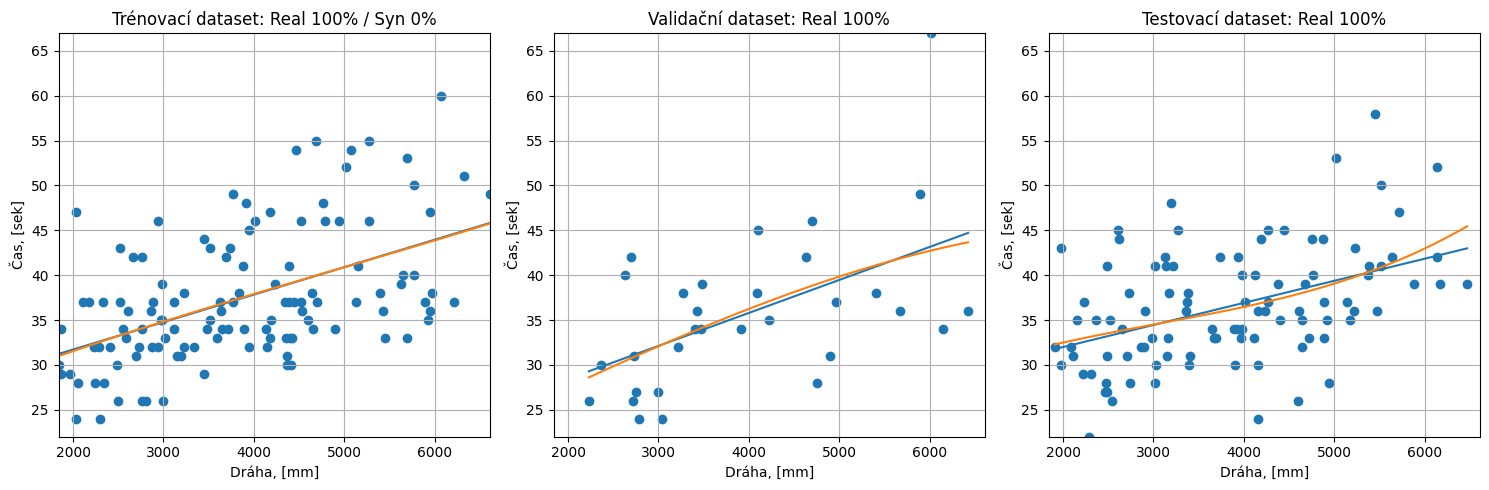

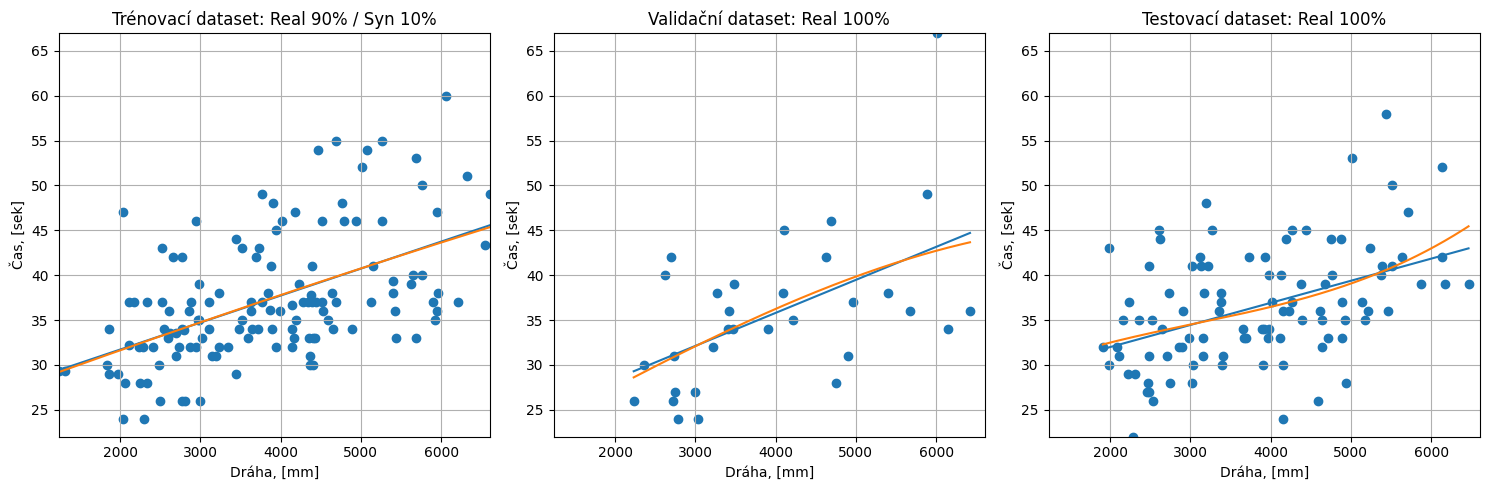

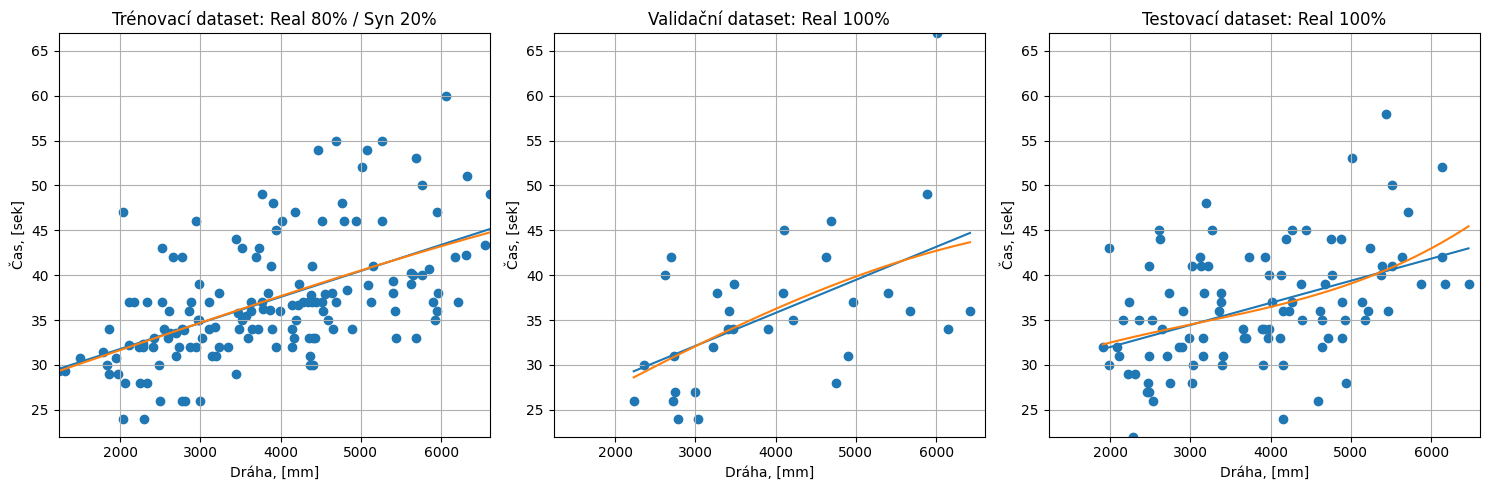

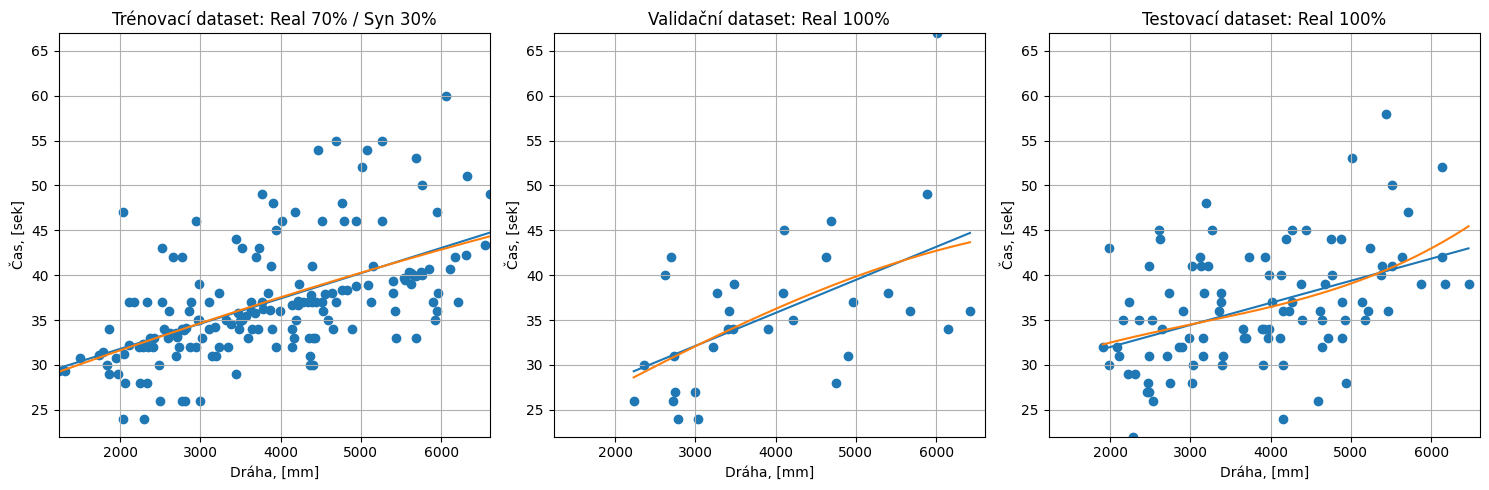

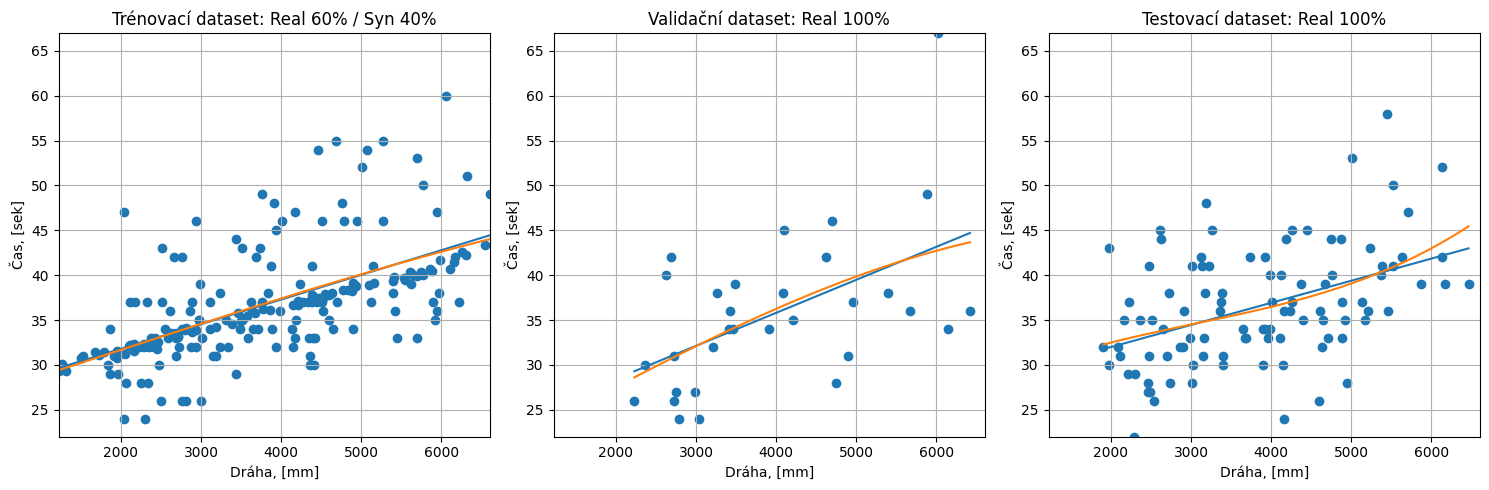

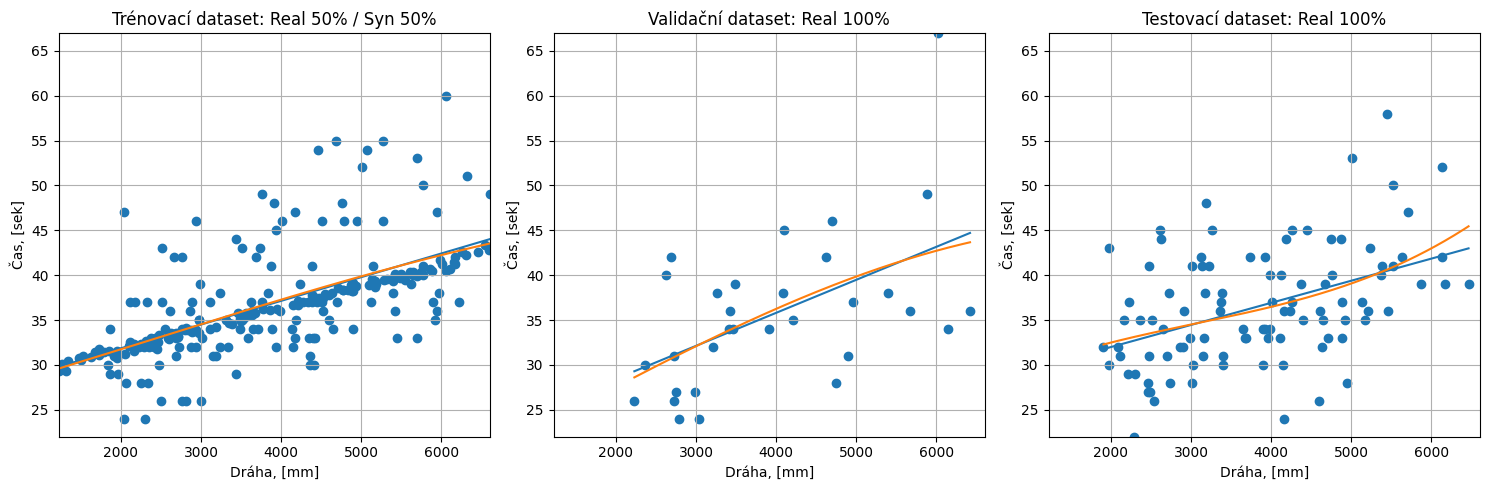

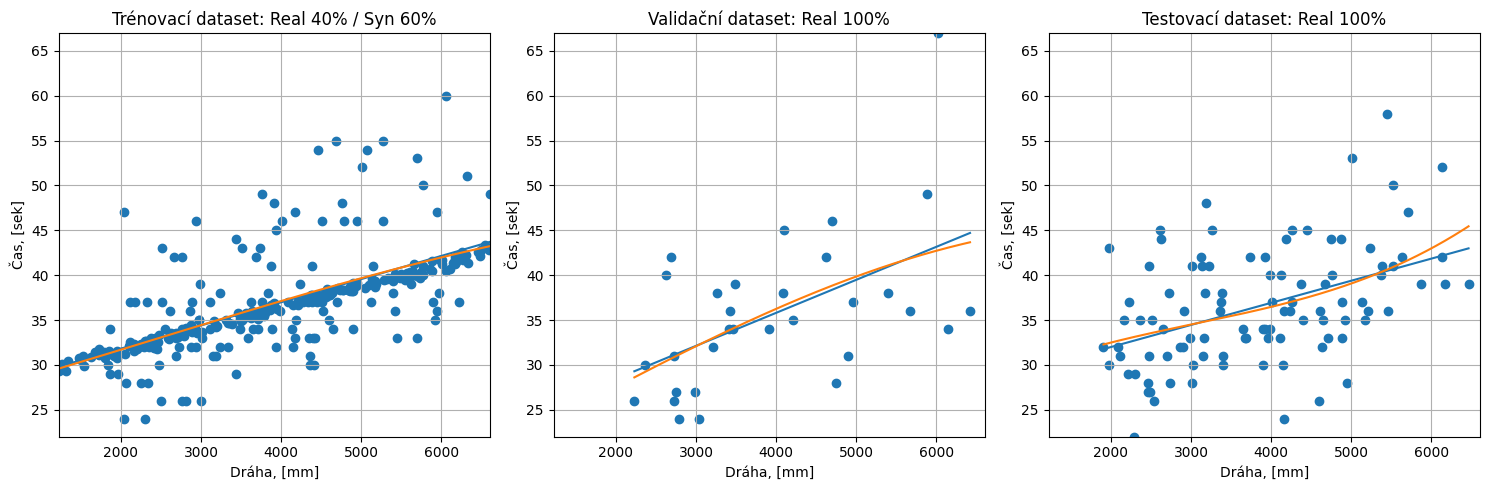

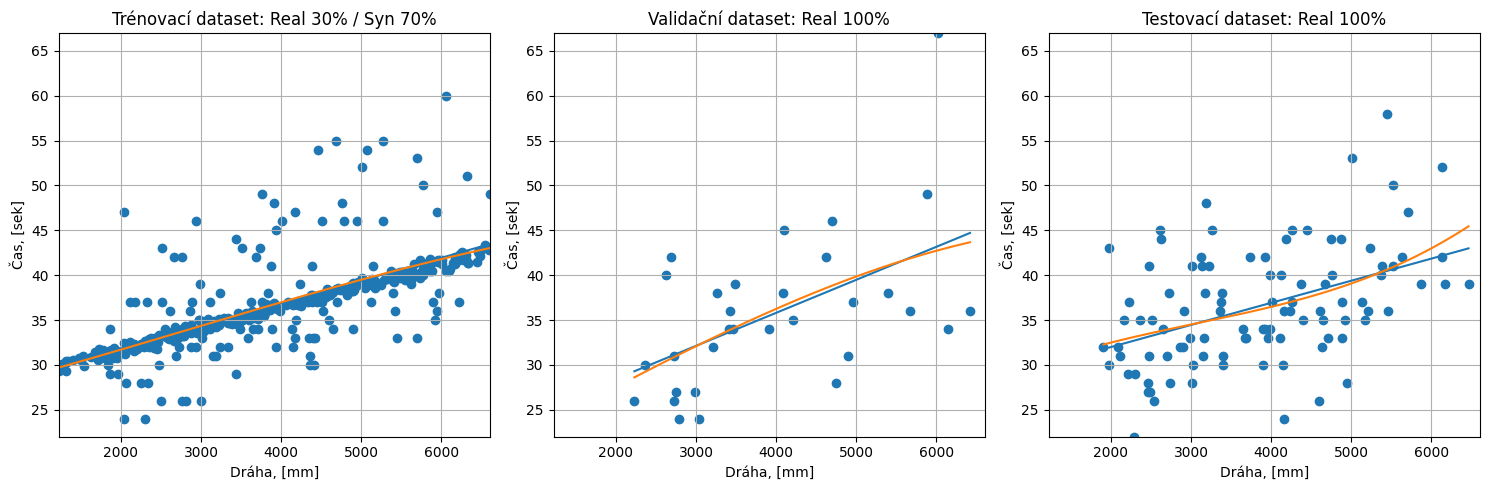

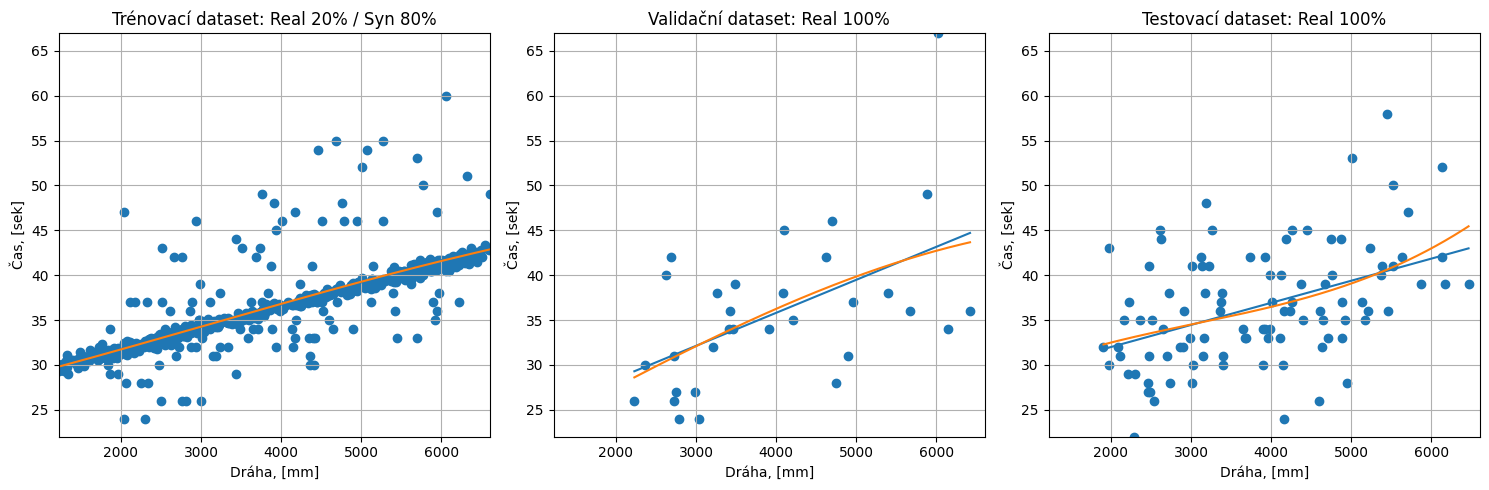

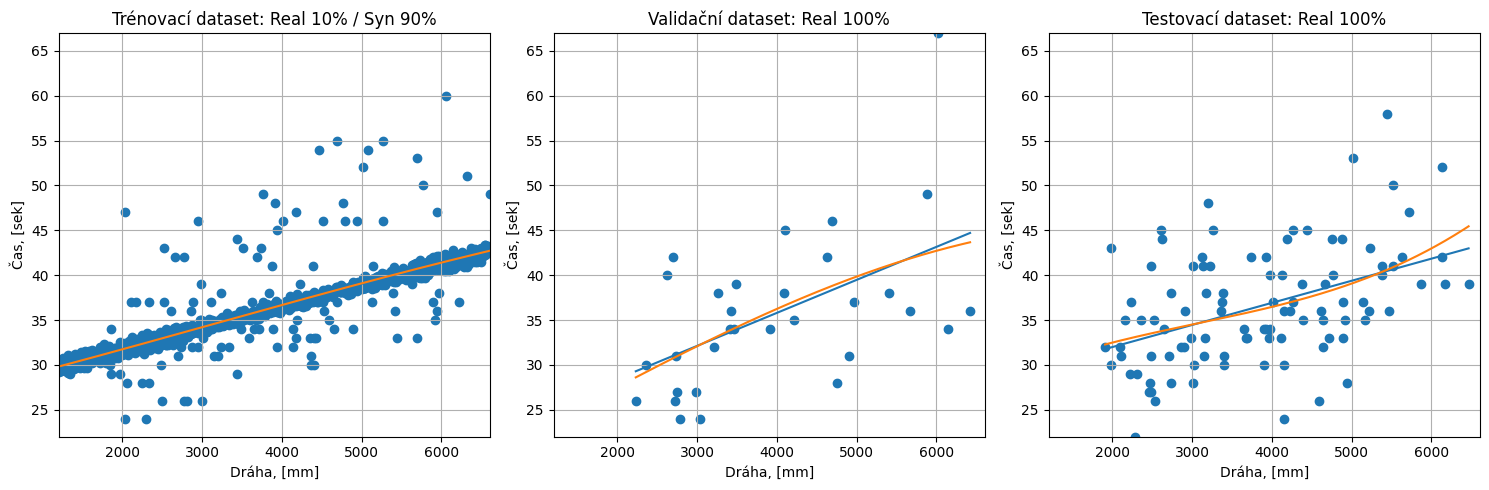

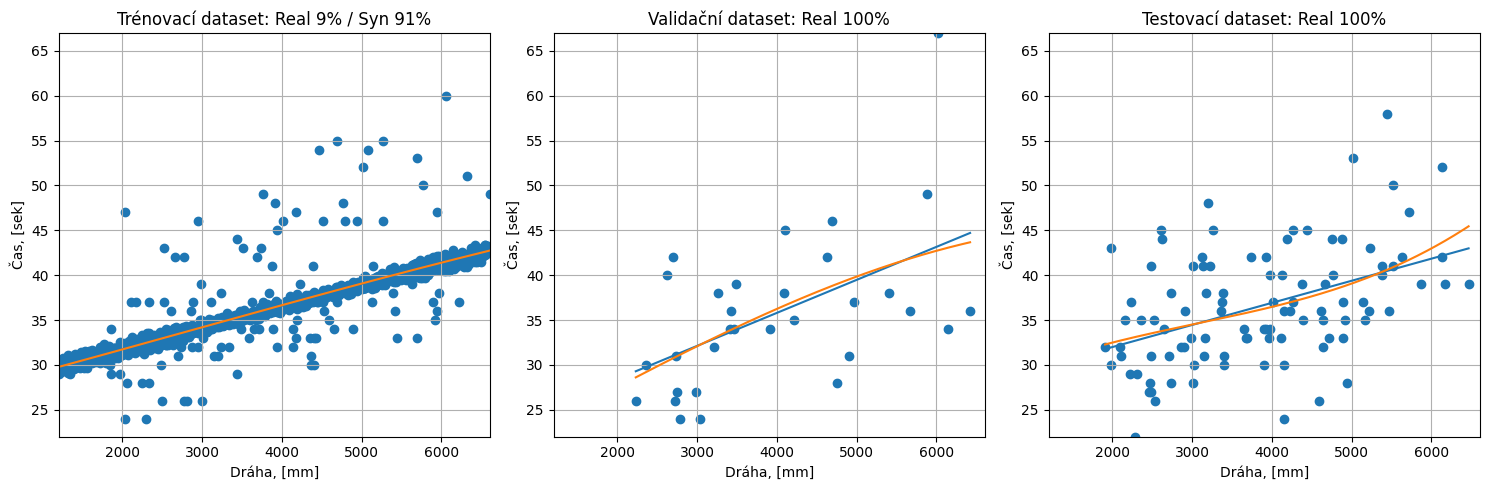

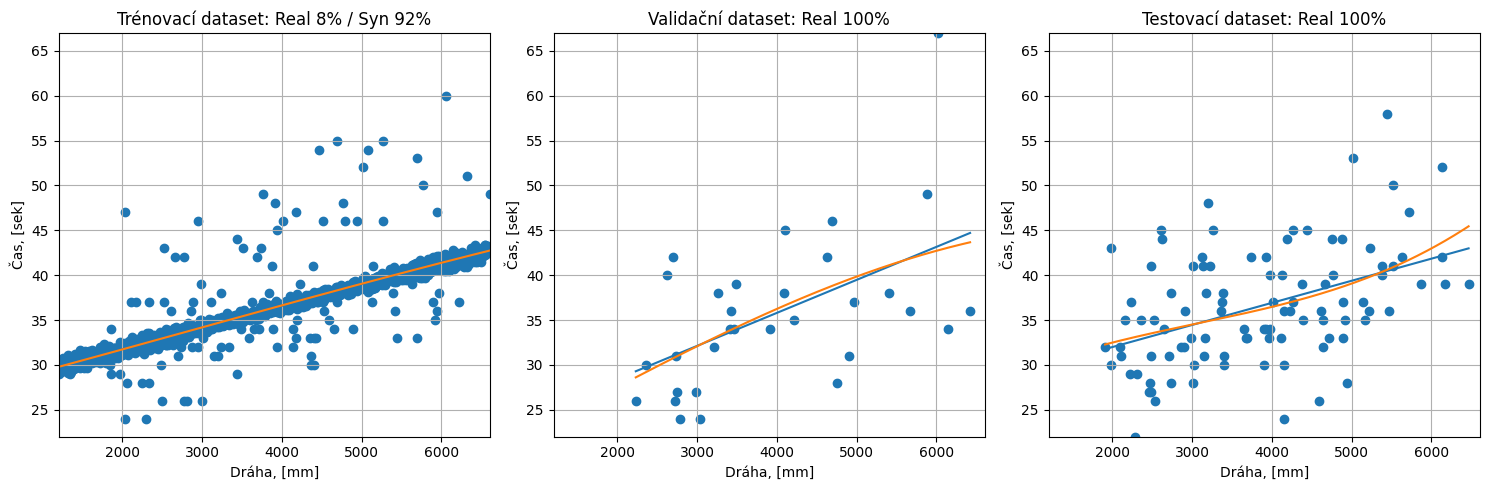

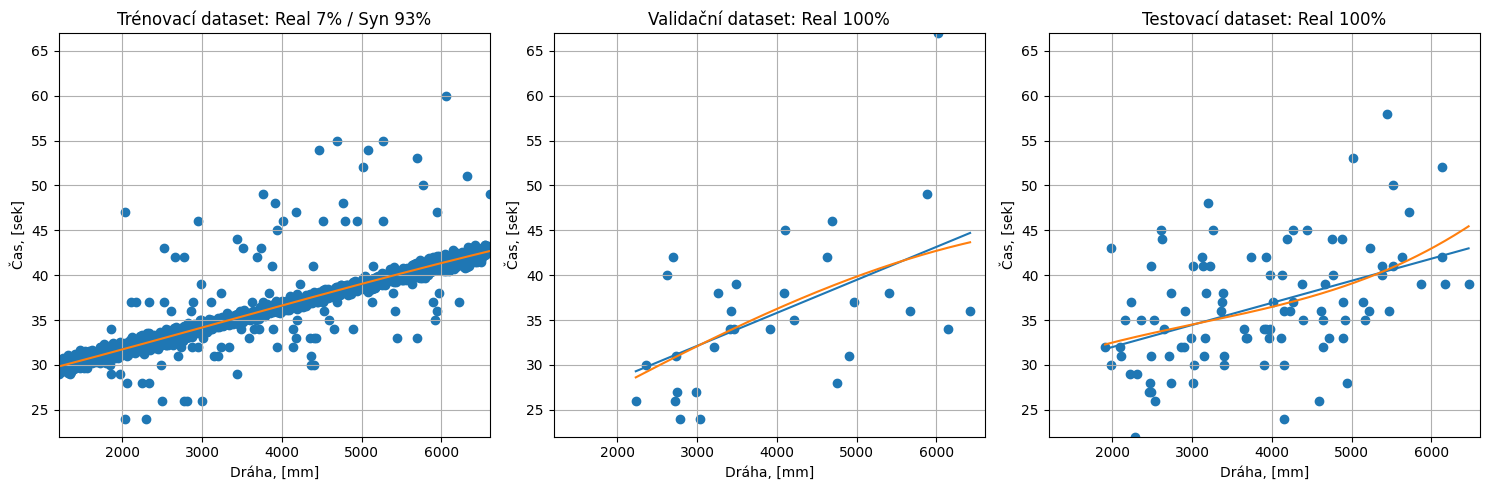

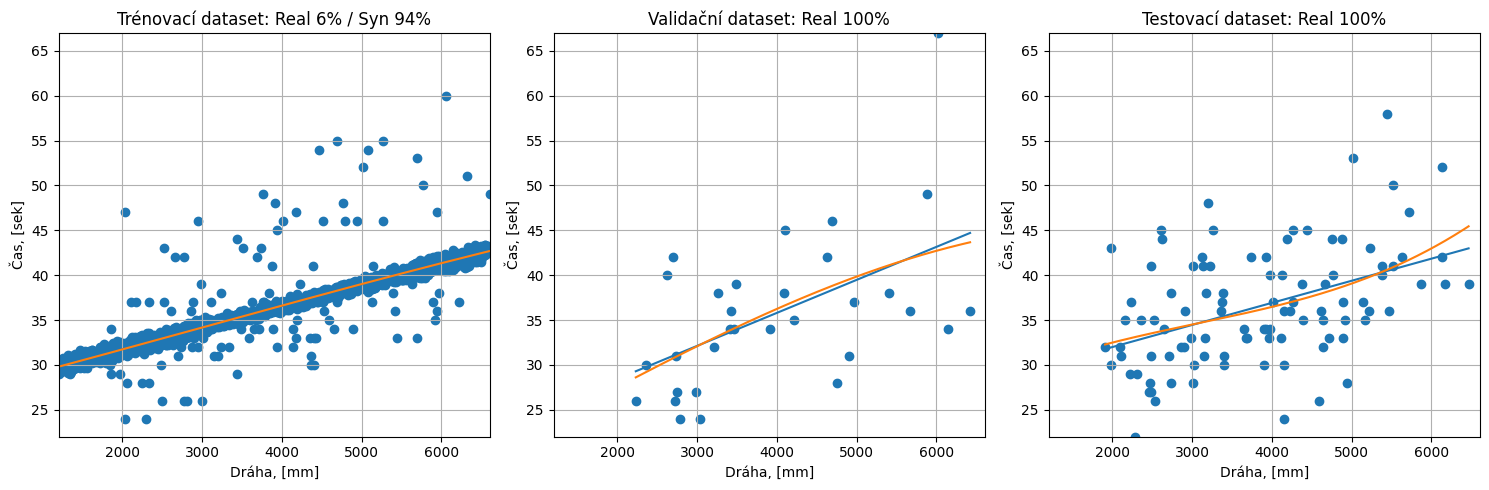

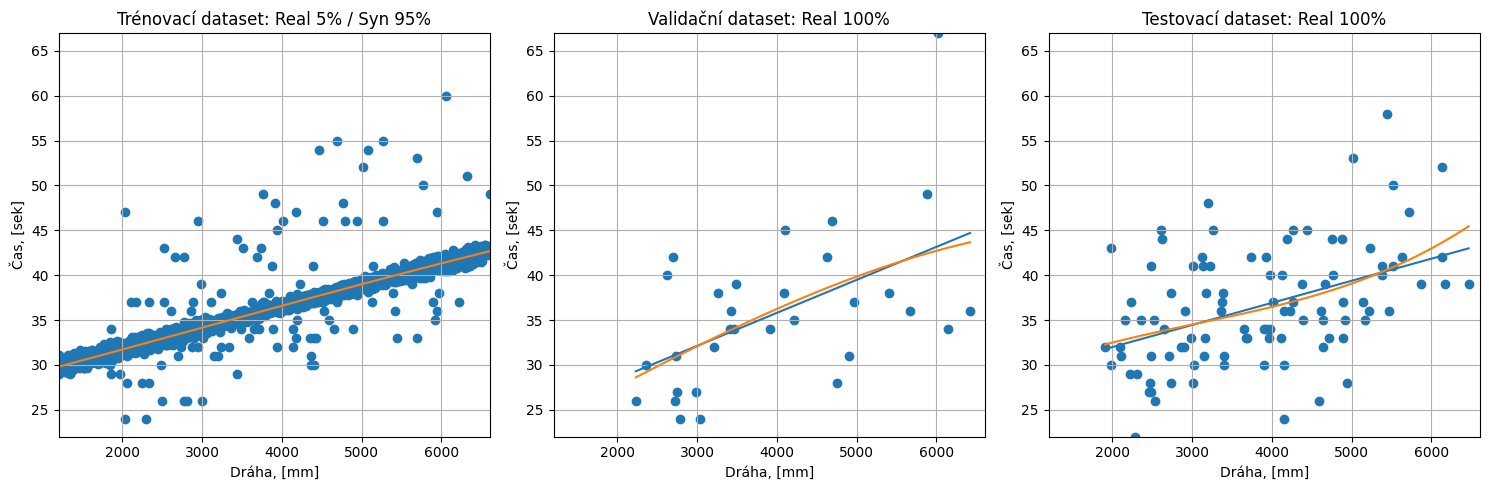

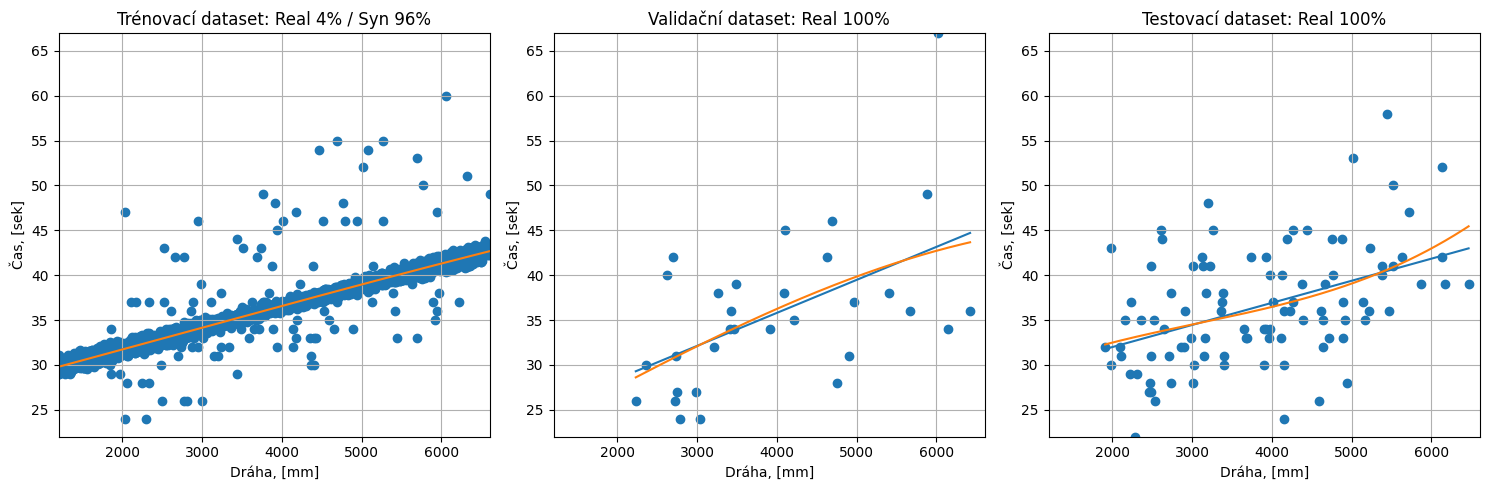

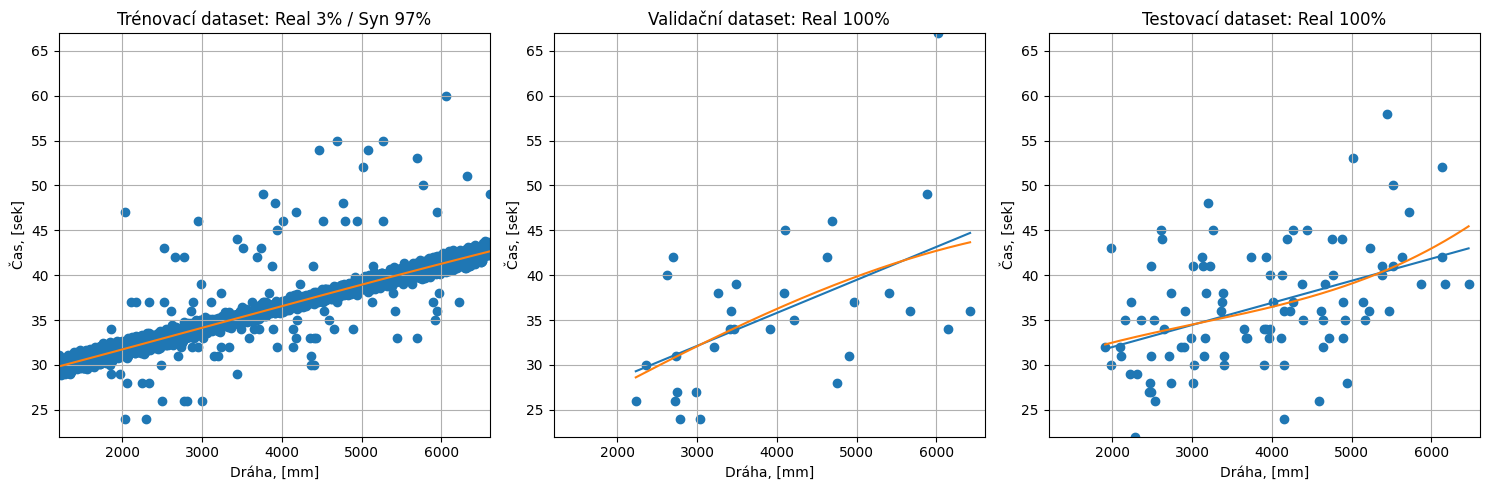

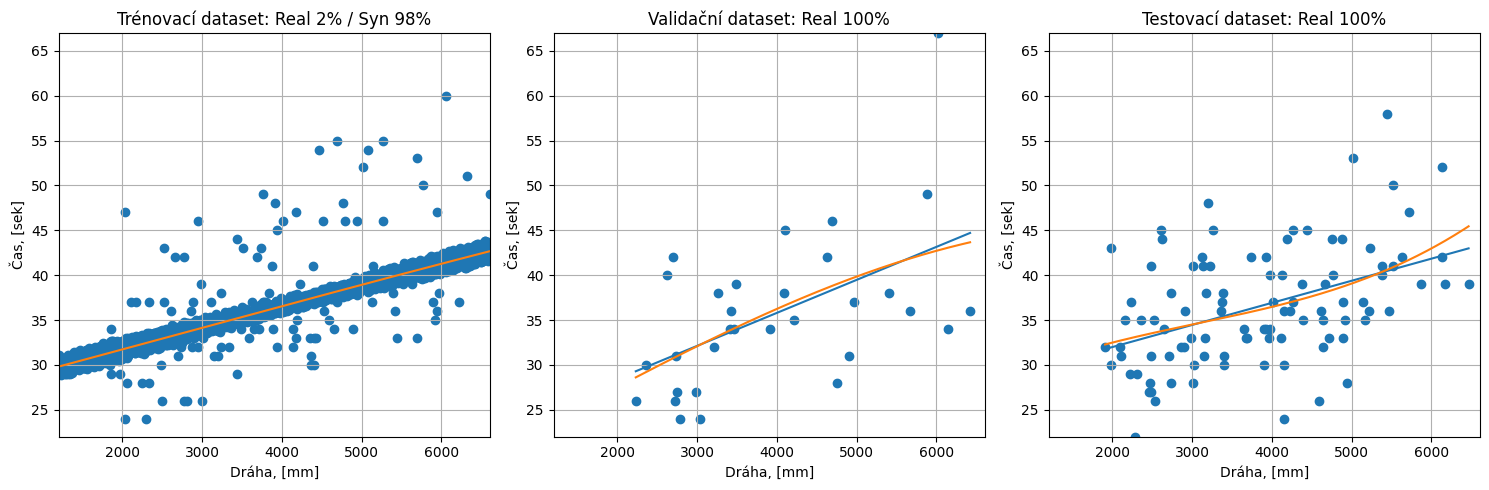

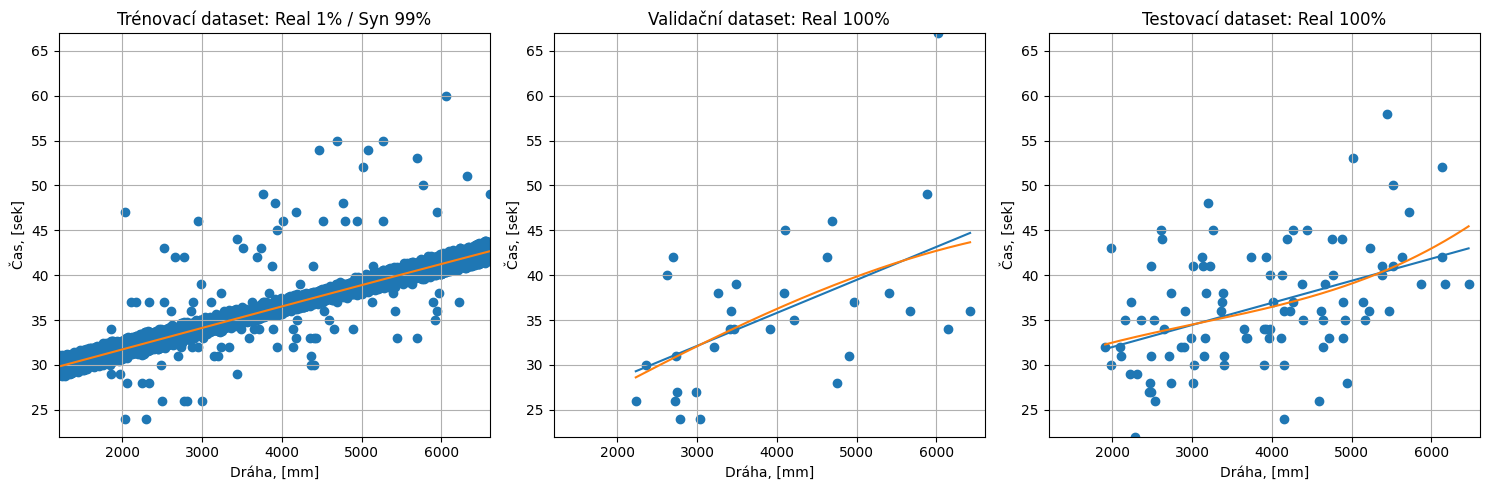

,Scenar,Train_samples,Degree,Val MSE,Val R2,Test MSE,Test R2
0,Poměr: 0.0,121,3,57.358081,0.210005,34.812342,0.167275
1,Poměr: 0.1,134,3,56.983244,0.215168,34.580655,0.172817
2,Poměr: 0.2,151,3,56.671027,0.219468,34.315206,0.179167
3,Poměr: 0.3,172,3,56.387917,0.223367,34.080180,0.184789
4,Poměr: 0.4,201,3,56.171236,0.226351,33.928242,0.188423
5,Poměr: 0.5,242,3,56.074353,0.227686,33.806948,0.191324
6,Poměr: 0.6,302,3,55.836698,0.230959,33.740381,0.192917
7,Poměr: 0.7,403,3,55.701857,0.232816,33.706721,0.193722
8,Poměr: 0.8,605,3,55.606282,0.234133,33.690849,0.194102
9,Poměr: 0.9,1210,3,55.592101,0.234328,33.716881,0.193479


In [17]:
# poměry syntetických dat pro trénování
syn_ratio = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

degree = 3

results_list = []

for ratio in syn_ratio:

    # 80 % train, 20 % val
    X_train_real, X_val, y_train_real, y_val = train_test_split(
        df_train_real[['dist']], df_train_real['total_time'], test_size=0.2, random_state=122
    )

    # počet syntetýckých vzorků
    n = len(y_train_real)
    s = int(n * ratio / (1 - ratio))
    df_syn = df_train_syn.sample(n=s, random_state=122)

    X_train_combined = pd.concat([X_train_real, df_syn[['dist']]])
    y_train_combined = pd.concat([y_train_real, df_syn['total_time']])


    # izolovaná testovací množina reálných dat
    X_real_test = df_val_real[['dist']]
    y_real_test = df_val_real['total_time']

    # === vytvoří 1 řádek, 3 sloupce ===
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    x_min = min(np.min(X_train_combined), np.min(X_val), np.min(X_real_test))
    x_max = max(np.max(X_train_combined), np.max(X_val), np.max(X_real_test))

    y_min = min(np.min(y_train_combined), np.min(y_val), np.min(y_real_test))
    y_max = max(np.max(y_train_combined), np.max(y_val), np.max(y_real_test))


    # ===== TRAIN =====
    plot_with_regression(
        axs[0],
        X_train_combined,
        y_train_combined,
        f"Trénovací dataset: Real {int(100 - ratio*100)}% / Syn {int(ratio*100)}%",
        degree,
        (x_min, x_max),
        (y_min, y_max)
    )

    # ===== VALIDATION =====
    plot_with_regression(
        axs[1],
        X_val,
        y_val,
        f"Validační dataset: Real 100%",
        degree,
        (x_min, x_max),
        (y_min, y_max)
    )

    # ===== REAL TEST =====
    plot_with_regression(
        axs[2],
        X_real_test,
        y_real_test,
        f"Testovací dataset: Real 100%",
        degree,
        (x_min, x_max),
        (y_min, y_max)
    )

    plt.tight_layout()
    plt.show()

    res = train_polynomial_model(
        X_train_combined, y_train_combined,
        X_val, y_val,
        X_real_test, y_real_test,
        degree=degree,
        scenario=f"Poměr: {ratio}",
        train_size=(s+n)
    )
    results_list.append(res)

results = pd.DataFrame(results_list)
results

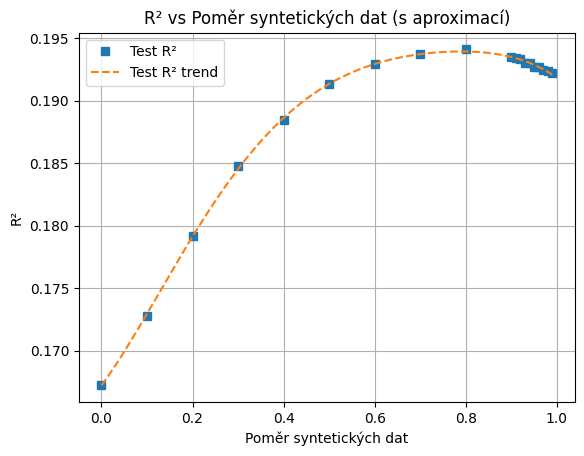

In [18]:
results['ratio'] = results['Scenar'].str.extract(r'(\d+\.\d+)').astype(float)
results['ratio'] = results['Scenar'].str.extract(r'(\d+\.\d+)').astype(float)

x = results['ratio'].values
val_r2 = results['Val R2'].values
test_r2 = results['Test R2'].values

# === aproximace (polynom) ===
deg = 5

val_coef = np.polyfit(x, val_r2, deg)
test_coef = np.polyfit(x, test_r2, deg)

val_poly = np.poly1d(val_coef)
test_poly = np.poly1d(test_coef)

x_curve = np.linspace(min(x), max(x), 200)

# === vykreslení ===
plt.figure()

#plt.plot(x, val_r2, 'o', label='Validation R²')
plt.plot(x, test_r2, 's', label='Test R²')

#plt.plot(x_curve, val_poly(x_curve), linestyle='--', label='Val R² trend')
plt.plot(x_curve, test_poly(x_curve), linestyle='--', label='Test R² trend')

plt.xlabel("Poměr syntetických dat")
plt.ylabel("R²")
plt.title("R² vs Poměr syntetických dat (s aproximací)")
plt.legend()
plt.grid(True)

plt.show()

Se zvyšujícím se podílem syntetických dat v trénovací množině dochází k mírnému poklesu validační chyby z hodnoty 57.36 na přibližně 55.56 a současnému nárůstu validačního koeficientu determinace z 0.210 na přibližně 0.235, což indikuje zlepšení aproximačních vlastností regresního modelu; na testovací množině však dochází k výraznějšímu zlepšení generalizační schopnosti modelu, kdy Test MSE systematicky klesá z hodnoty 34.81 na minimum přibližně 33.69 při podílu syntetických dat okolo 80 % a současně Test R² roste z 0.167 na maximum přibližně 0.194, přičemž při dalším navyšování podílu syntetických dat nad tuto hranici dochází pouze k velmi mírnému zhoršení Test MSE až na hodnoty okolo 33.77 a poklesu Test R² na přibližně 0.192; tento vývoj naznačuje, že odstranění extrémních odlehlých hodnot vedlo k redukci rozptylu cílové proměnné a ke stabilizaci regresního vztahu mezi délkou trajektorie a dobou cyklu, což umožnilo lepší generalizaci modelu, přičemž i nadále zůstává vysvětlující schopnost deterministické složky omezená, neboť délka trajektorie vysvětluje maximálně přibližně 19 % variability celkové doby pracovního cyklu a dominantní podíl variability je nadále způsoben stochastickými provozními vlivy. Na testovací množině  výkonnost modelu dosahuje maxima přibližně při podílu syntetických dat 70 %

### Optimální poměr syntetických dat: 60 - 80 %

### Autor / Organizace / Datum

Vjačeslav Usmanov, ČVUT v Praze, Fakulta stavební

###### Přehled změn


|  Datum (YYYY-MM-DD) |  Verze | Autor změny  |  Popis změny |
|---|---|---|---|
| 2026-02-05 | 1.1 | Vjačeslav Usmanov| added AI_01_Polynomial_Regression.ipynb |
| 2026-02-20 | 1.2 | Vjačeslav Usmanov| changed AI_01_Polynomial_Regression.ipynb |